# Análise e identificação de produtos únicos do marketplace.

### Neste notebook descrevemos um pipeline com técnicas de ML para identificação de produtos únicos do marketplace online. A estratégia aqui proposta tem como objetivo principal superar as dificuldades particulares de problemas de classificação de dados com grandes número de rótulos (acima de dezena de milhares). Desta forma, o trabalho é divido nas seguintes partes: (I) Análise da base de dados Product Clustering, Matching & Classification (Kaggle), (II) Construção de representações vetoriais para nome dos produtos da base de dados (III) Análise do desempenho de classificadores da biblioteca padrão sklearn para bases com grandes números de rótulos (IV) Classificação de produtos em categorias e (V) identificação de produtos únicos com aprendizado não supervisionado.


* Dependências:
    * numpy
    * scipy
    * matplotlib
    * pandas
    * sklearn
    * gensim

## Link para download do notebook: https://github.com/warSantos/ProductMatching/
## Link para download da base de dados: https://www.kaggle.com/lakritidis/product-clustering-matching-classification
## Link para apresentação: https://youtu.be/nBPmkygnTaw

In [5]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, ward, complete, centroid, fcluster, average
#from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Módulos locais

from utils.text_clean import clean_text
from utils.word2vec import Word2VecModel
from utils.doc2vec import Doc2VecModel
from utils.fasttext import FastTextModel

from utils.clfs import Clfs

from utils.plots import plot_acc_classes, plot_dists
from utils.evaluation import cluster_accuracy
from utils.tfidf import tfidf

# Warning control
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# Análise da base de dados

### A base de dados utilizada neste trabalho foi retirada do portal Kaggle no referente link https://www.kaggle.com/lakritidis/product-clustering-matching-classification .

### O conjunto de dados conta com coleções de produtos de dois e-comerces PriceRunner e Skroutz. Neste trabalho utilizaremos a base de dados PriceRunner devido base ser mais condizente para as finalidades deste trabalho. Mais especificamente, a base de dados Skroutz contem grande desbalanceio no volume de dados por categoria, com maior foco um único produto (relógios).

### A base de dados contém formato tabular, com os seguintes atributos: 

* p_id: identificador de um produto (único em toda a base)
* p_title: o nome de um produto (p.ex.: processador AMD Rayzen 3.4 GHZ)
* vendor_id: o fabricante de um produto (p.ex.: AMD)
* cluster_id: o identificador de um produto (p.ex.: processador AMD Rayzen 3.4 GHZ e AMD Rayzen 3.4 GHZ são o mesmo produto porém com nomes ligeiramente diferentes. Logo possuem o mesmo cluster id)
* cluster_title: nome referente ao cluster do produto
* cat_id: o identificador referente a categoria de um produto (p.ex.: CPUs contém cat_id 2615)
* cat_title: título de uma categoria.

### Neste trabalho utilizamos os atributos cat_id, cat_title cluster_id e p_title. Utilizamos estes dois atributos somente, porque no geral, são os atributos presentes na grande parte das bases similares a esta. Desta forma, nossa técnica pode ser estendida a mais problemas similares sem perda de generalidade.

In [6]:
headers = ["p_id", "p_title", "vendor_id", "cluster_id", "cluster_title", "cat_id", "cat_title"]
df = pd.read_csv('datasets/pricerunner_aggregate.csv', header=0, names = headers)
#df = df[df.cat_id == 2612]
df.head()

,p_id,p_title,vendor_id,cluster_id,cluster_title,cat_id,cat_title
0,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,6,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,6,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [7]:
df[df.cluster_id == 1]

,p_id,p_title,vendor_id,cluster_id,cluster_title,cat_id,cat_title
0,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,6,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,6,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
5,7,apple iphone 8 plus 64 gb space grey,7,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
6,8,apple iphone 8 plus 64gb space grey,8,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
7,9,apple iphone 8 plus 64gb space grey,9,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
8,10,apple iphone 8 plus 64gb space grey,10,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
9,11,apple iphone 8 plus 5.5 single sim 4g 64gb silver,11,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


In [8]:
# Número de produtos únicos.
print("Número de instâncias: ", len(df))
# Número de clusters.
print("Number of clusters: ", len(set(df.cluster_id)))
# Número de categorias.
print("Number of categs: ", len(set(df.cat_id)))
# Quantidade de nomes únicos.
print("Number of uniq names: ", len(set(df.cluster_title)))

Número de instâncias:  35310
Number of clusters:  13233
Number of categs:  10
Number of uniq names:  12849


## Número de produtos por categoria

### A base possui distribuição de produtos entre suas categorias um pouco desbalanceada, mas nada que afete negativamente as futuras análises.

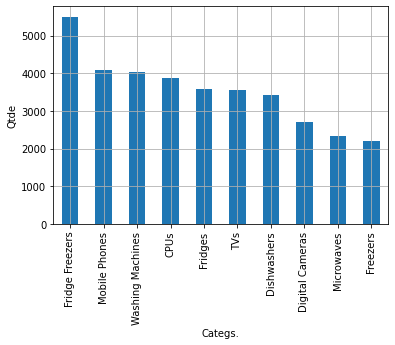

In [46]:
_ = df.cat_title.value_counts().plot(kind="bar", xlabel="Categs.", ylabel="Qtde", grid=True)

### Tipos de protudos e categorias existentes na base de dados.

In [47]:
df.drop_duplicates(subset=["cat_id","cat_title"])

,p_id,p_title,vendor_id,cluster_id,cluster_title,cat_id,cat_title
0,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4080,10035,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs
7644,13771,amd ryzen 7 eight core 1700x 3.80ghz socket am...,5,5851,AMD Ryzen 7 1700X 3.4GHz Box,2615,CPUs
11506,21063,canon ixus 185 schwarz,247,38848,Canon IXUS 185,2617,Digital Cameras
14203,23766,bosch hmt72m450b silver freestanding microwave...,132,39647,Bosch HMT72M450B Stainless Steel,2618,Microwaves
16545,26300,bosch sms25aw00g 60cm serie 2 freestanding dis...,301,40464,Bosch SMS25AW00G White,2619,Dishwashers
19969,30131,bosch wiw28300gb serie 6 8kg 1400rpm integrate...,6,41862,Bosch WIW28300GB,2620,Washing Machines
24013,34726,bosch gud15a50gb/02 freezer drawer,3,43262,Bosch GUD15A50GB Integrated,2621,Freezers
26225,37216,bosch kgn34nw3ag fridge freezer,129,44038,Bosch KGN34NW3AG White,2622,Fridge Freezers
31726,43392,bosch kur15a50gb built in under larder fridge ...,125,46113,Bosch KUR15A50GB Integrated,2623,Fridges


##  Média e desvio padrão da variação de produtos associados a um único cluster_id

### A base de dados, como visto nas células seguintes possuem uma baixo número de variações de produtos por cluster_id. Esta característica torna a identificação de produtos únicos mais difícil que o usual para abordagens baseadas em aprendizado supervisionado.

In [48]:
cats = list(set(df.cat_title))
cats.sort()
values = []
mm = 0
for cat in cats:
    cat_df = df[df.cat_title == cat]
    pus_by_cat = cat_df.cluster_id.value_counts()
    m = np.mean(pus_by_cat.values)
    s = np.std(pus_by_cat.values)
    values.append([cat, m, s])
    mm += m

print("Média: ", mm/10)

info = pd.DataFrame(values, columns=["Cat", "Mean", "Std"])
info.head(20)

Média:  2.7844075463895592


,Cat,Mean,Std
0,CPUs,1.955443,1.473492
1,Digital Cameras,3.782609,3.546388
2,Dishwashers,2.502924,2.157536
3,Freezers,2.910526,2.217726
4,Fridge Freezers,2.753253,2.280543
5,Fridges,2.610342,1.923242
6,Microwaves,2.983439,2.280570
7,Mobile Phones,2.394366,2.678924
8,TVs,2.784375,3.164067
9,Washing Machines,3.166797,2.855358


##  Plot da quantidade de produtos associados a um cluster_id

### Como podemos ver nos dois seguintes gráficos abaixo, um grande número de cluster_id estão associados a um ou dois produtos (mesmo produto com mais de um nome). Produtos com até duas variantes podem ser classificados, apesar de ser uma tarefa extremamente difícil ensiar o classificador a aprender a classificar uma classe com apenas uma observação desta. Porém, para produtos de apenas uma classe, a tarefa se torna não factível e consequentemente, dentro do cenário de classificação o melhor esforço consiste em atribui ao produto um rótulo sem classe ou atribuir a este uma classe de objetos mais similares a sua possível (menor erro semântico).

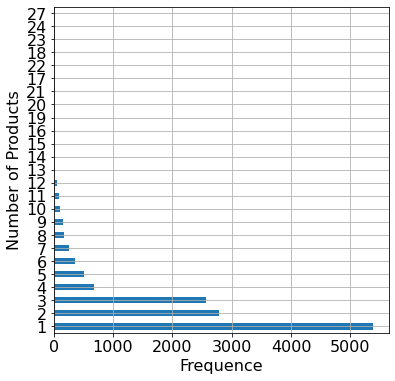

In [8]:
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(xlabel="Frequence", fontsize=16)
plt.ylabel(ylabel='Number of Products', fontsize=16)
_ = df.cluster_id.value_counts().value_counts().plot(kind='barh', grid=True, figsize=(6,6))


## Plot da quantidade de nomes únicos associados por cluster_id

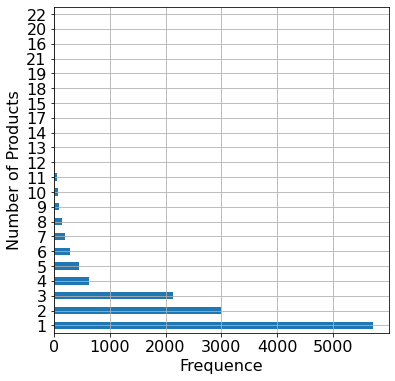

In [9]:
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(xlabel="Frequence", fontsize=16)
plt.ylabel(ylabel='Number of Products', fontsize=16)
_ = df.drop_duplicates(subset=['p_title']).cluster_id.value_counts().value_counts().plot(kind='barh', grid=True, figsize=(6,6))

# Construção de atributos (Features)

### Antes de gerar os vetores representantes de cada produto em nossa base, aplicamos uma etapa de pré processamento que consiste em converter o texto para caixa baixa, remover pontos, caracteres inválidos, stop words (palavras irrelevantes) e números.

### Para classificar e agrupar os produtos utilizamos diferentes representações vetoriais para estes. Mais especificamente, utilizamos quatro diferentes técnicas baseadas em word embeddings: média de vetores word2vec, doc2vec, média de vetores fasttext e TF-IDF.

### Removemso da base também, produtos sem nome.

In [9]:
df = df[ (df.p_title.notna()) & (df.p_title.notnull()) ]

In [10]:
# Atribuindo a cada produto da base um inteiro com a quantidade de nomes
# diferentes estão associados ao seu ID (incluindo ele).
counts = df.cluster_id.value_counts()
freqs = [ counts[cid] for cid in df.cluster_id ]
df["freqs"] = freqs

In [11]:
# Pré processamento do nome dos produtos.
feat_tokens = clean_text(df.p_title.values, accept_num=False)

In [12]:
# Célula de exmplo do resultado do pré processamento para a seguinte string.
clean_text(["Olá mundo! São 13:25, dia 31/08 "], accept_num=False)

[['olá', 'mundo', 'são', 'dia']]

In [13]:
# Construção dos modelos de embeddings.
w2v_params = {
    "sentences": feat_tokens,
    "vector_size": 100,
    "sg": 0,
    "window": 5,
    "epochs": 10,
    "workers": 10
}

w2v = Word2VecModel(feat_tokens, params=w2v_params)

d2v_params = {
    "documents":  feat_tokens,
    "vector_size": 100,
    "dm": 0,
    "window": 5,
    "epochs": 10,
    "dbow_words": 1,
    "workers": 10
}

d2v = Doc2VecModel(feat_tokens, params=d2v_params)

fasttext_params = {
    "sentences": feat_tokens,
    "vector_size": 100,
    "sg": 0,
    "window": 5,
    "epochs": 10,
    "workers": 10
}

fasttext = FastTextModel(feat_tokens, params=fasttext_params)

In [14]:
representacoes = {}
representacoes["word2vec"] = w2v.transform(feat_tokens)
representacoes["doc2vec"] = d2v.transform(len(feat_tokens))
representacoes["fasttext"] = fasttext.transform(feat_tokens)
representacoes["tfidf"] = tfidf(df.p_title.values, ngram_range=(1,1), min_df=1)


# Verificação dos classificadores para o problema PU.

### Configuração de parâmetros para teste do notebook ou para excução final. Se a flag TESTE_NOTEBOOK estiver ativada (True), parâmetros par fins de verificação de funcionamento serão executados. Função utilizada para correção de erros e entendimento do notebook. Essa opção também consome menor tempo.

### Se a flag TESTE_NOTEBOOK estiver desativada (False), o notebook será por completo com todos os parâmetros configurados para geração de resultados padrão. Esta opção consome mais tempo e recursos computacionais.

### Para rodar os experimentos completos novamente, deve também ser ativada a flag RUN_AGAIN com valor True.


In [19]:
_ = """
classifiers = {
    "RandomForestClassifier": RandomForestClassifier(n_jobs=10, random_state=seed),
    "LogisticRegression": LogisticRegression(max_iter=400, multi_class='multinomial', n_jobs=10, random_state=seed),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=seed),
    "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10),
    "SVC": SVC(random_state=seed)
}
"""

r = np.random
seed = r.randint(0, 2147483647 * 2)

TESTE_NOTEBOOK = True

LIMIT_CLASSES = None
classifiers = None
RUN_AGAIN = False

if TESTE_NOTEBOOK:
    LIMIT_CLASSES = 5
    classifiers = {
        "RandomForestClassifier": RandomForestClassifier(n_jobs=10, random_state=seed),
        "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=10, random_state=seed),
        "KNeighborsClassifier": KNeighborsClassifier(n_jobs=10)
    }
else:
    LIMIT_CLASSES = 30
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=2000, multi_class='multinomial', n_jobs=10, random_state=seed)
    }

## Desempenho dos notebooks pelo número de classes no dado de treino

### Nesta análise, verificamos do desempenho dos classificadores conforme mais produtos são adicionados a classificação e conforme aumentamos o limiar variantes de produtos (nomes diferentes associados a um mesmo cluster id) mínimo da base de treino.

### Como podemos ver no gráfico da figura abaixo, conforme adicionamos mais categorias para serem classificadas (mais variantes de nomes de um único produto) existe uma tendência de queda no desempenho de todos os algoritmos, sendo indiferente a alteração da representação vetorial. Outro fator importante, é o custo de processamento. Para separar grandes números de classes, cada algoritmo deve fazer vários separadores (classificadores) para separar os diferentes produtos entre si. Esta condição aumenta o consumo de computacional e de tempo necessário para o treino dos algortimos, tornado inviável a utilzação da estratégias de classificação tradicionais para tal tarefa.

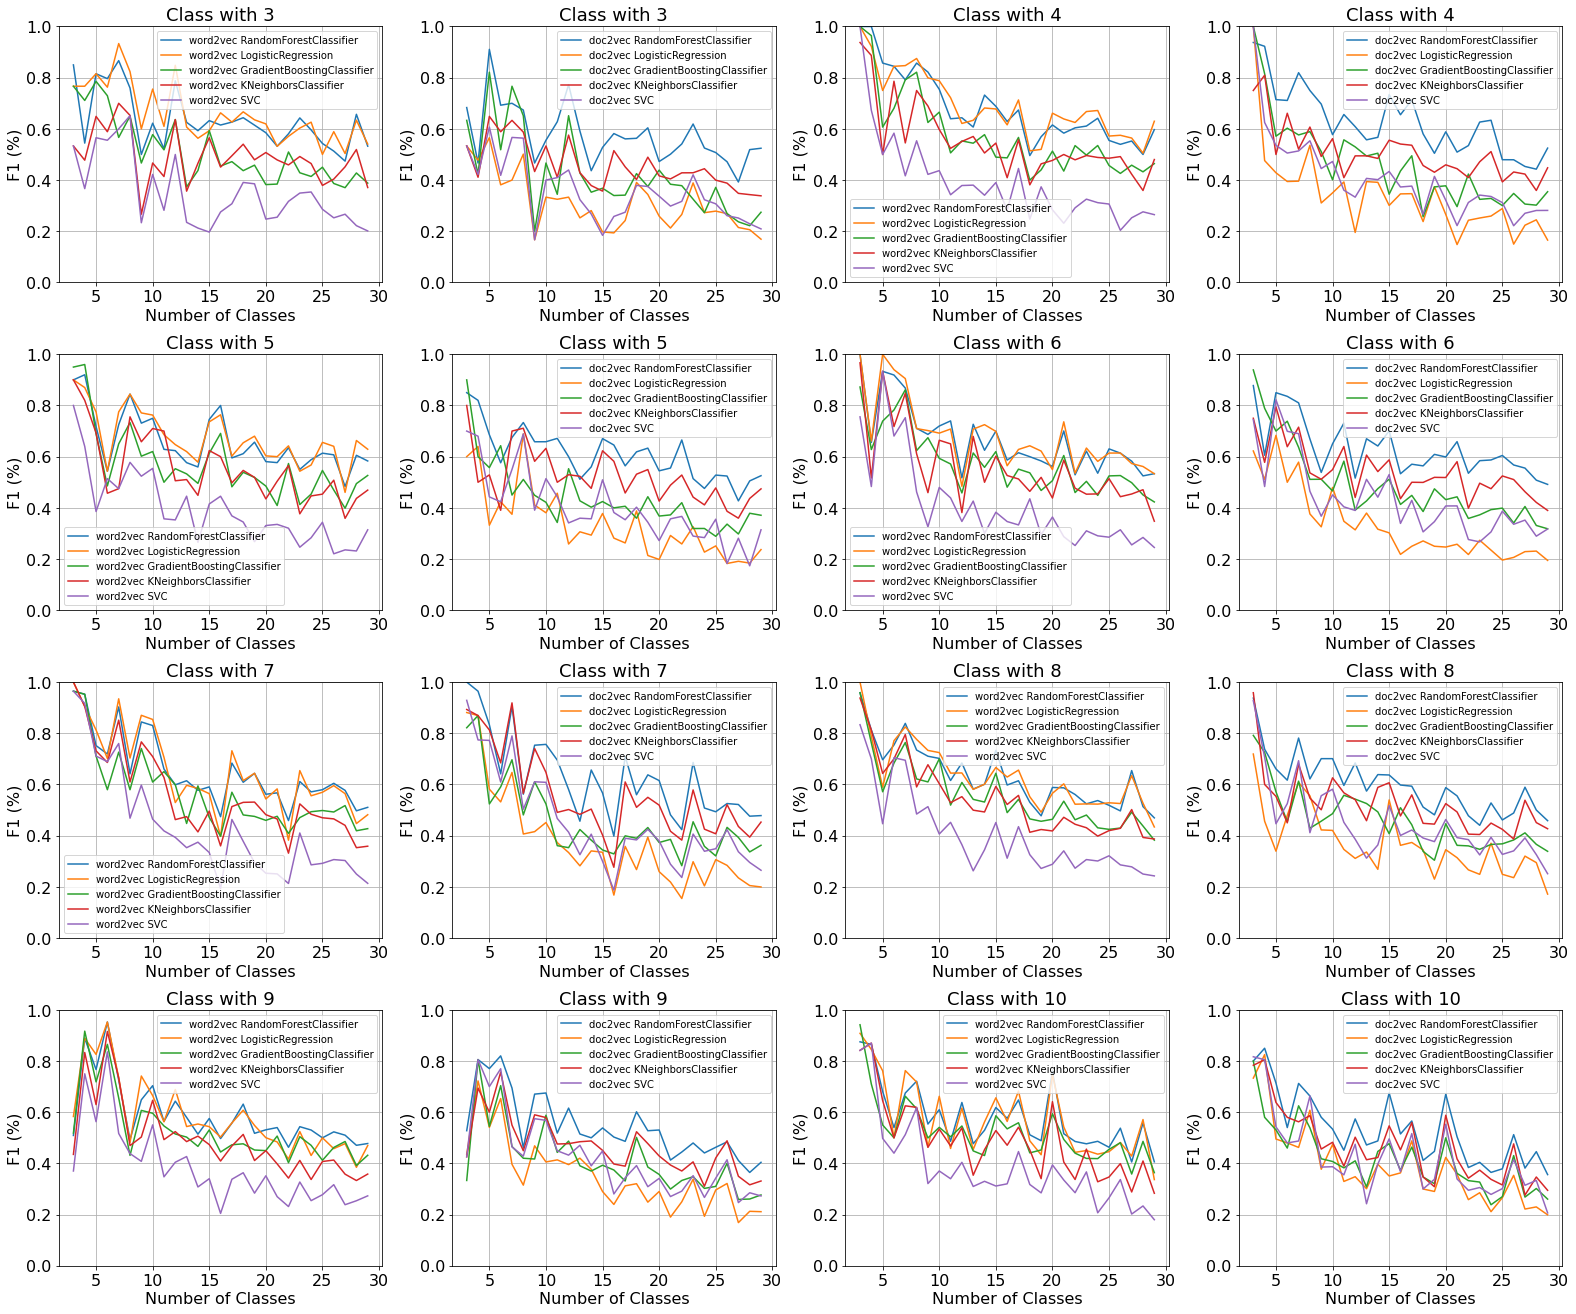

In [33]:
pipeline = Clfs()

# Geração da semente aleatória.
r = np.random
seed = r.randint(0, 2147483647 * 2)

timestamp = time.strftime("%Y-%m-%d - %H:%M:%S")
results = {}
if RUN_AGAIN:
    for n_class in range(3, 11):
        ids = list(set(df[(df.freqs >= n_class) & (df.cat_id == 2622)].cluster_id))
        results[n_class] = {}
        for i in range(3, LIMIT_CLASSES):
            results[n_class][i] = {}
            # Escolhendo um sample de produtos aleatório da base.
            clusters_ids = np.random.choice(ids, i)
            set_sample = df.cluster_id.isin(clusters_ids)
            # Para cada representação.
            for rep in representacoes:
                target = df[set_sample]["cluster_id"].values
                features = representacoes[rep][set_sample]
                results[n_class][i][rep] = pipeline.fast_avaliation(
                    classifiers, features, target, n_folds=n_class
                )
    with open(f"tables/f1_classes_{timestamp}.json", "w") as fd:
        json.dump(results, fd)
else:
    with open("tables/f1_classes_2021-08-31 - 18:49:46.json", "r") as fd:
        results = json.load(fd)

plot_acc_classes(results, LIMIT_CLASSES, timestamp)

# Classificação de produtos por categoria.

### Nesta seção avaliamos o desempenho de diferentes classificadores para distribuir os produtos entre suas categorias.

In [34]:
pipeline = Clfs()

if RUN_AGAIN:
    results = []
    scores_rep = {}
    for rep in representacoes:
        scores_clfs = pipeline.fast_avaliation(classifiers, representacoes[rep], df.cat_id)
        for clf in scores_clfs:
            results.append([rep, clf, scores_clfs[clf]["mean_f1"], scores_clfs[clf]["std_f1"]])

    cat_results = pd.DataFrame(results, columns=["Rep", "Clf", "MeanF1", "StdF1"])
    timestamp = time.strftime("%Y-%m-%d - %H:%M:%S")
    cat_results.to_csv(f'tables/f1_rep_{timestamp}.csv', index=False)
    cat_results.head(100)
else:
    df_all = pd.read_csv('tables/f1_rep_2021-08-30 - 13:48:57.csv')

## Desempenho dos classificadores

### Nesta etapa verificamos o desempenho dos classificadores para duas diferentes representações word2vec e doc2vec. Como podemos ver os classificadores tiveram desempenho muito próximos com o Random Forest sobresaindo os demais, acompanhado do SVM e Regressão logística. Como as futuras análises exigem várias execuções dos classificadores, seguiremos as futuras análises com os classificadores Random Forest, KNN e Regressão Logística para economizar tempo e recursos computacionais, uma vez que os algoritmos SVM e Gradient Boost são relativamente mais caro que os demais.

In [35]:
df_all.head(100)

,Rep,Clf,MeanF1,StdF1
0,word2vec,RandomForestClassifier,0.930388,0.026703
1,word2vec,LogisticRegression,0.924667,0.031563
2,word2vec,GradientBoostingClassifier,0.919428,0.031668
3,word2vec,KNeighborsClassifier,0.907335,0.027689
4,word2vec,SVC,0.924979,0.036545
5,doc2vec,RandomForestClassifier,0.870292,0.020971
6,doc2vec,LogisticRegression,0.854177,0.028176
7,doc2vec,GradientBoostingClassifier,0.859558,0.024979
8,doc2vec,KNeighborsClassifier,0.863466,0.018422
9,doc2vec,SVC,0.874398,0.027497


## Avaliando os classificadores para cada estratégia de representação, pdoemos notar que o classificador Random Forest obteve o melhor desempenho, atingindo 94.66% de MacroF1, com as representações geradas com o modelo FastText.

In [36]:
pd.read_csv('tables/f1_rep_2021-09-01 - 09:13:23.csv').head(100)

,Rep,Clf,MeanF1,StdF1
0,word2vec,RandomForestClassifier,0.929085,0.028706
1,word2vec,LogisticRegression,0.920023,0.033956
2,word2vec,KNeighborsClassifier,0.908440,0.027395
3,doc2vec,RandomForestClassifier,0.869612,0.018861
4,doc2vec,LogisticRegression,0.853214,0.026782
5,doc2vec,KNeighborsClassifier,0.865477,0.020503
6,fasttext,RandomForestClassifier,0.946616,0.020767
7,fasttext,LogisticRegression,0.931068,0.030714
8,fasttext,KNeighborsClassifier,0.926282,0.019663
9,tfidf,RandomForestClassifier,0.939762,0.024078


# Agrupamento de PUs por categoria

### Para cada categoria inicial da base de dados vamos agrupar os produtos únicos com a técnica de clustering hierárquico. Utilizamos essa técnica isoladamente por categoria para que essa escale computacionalmente com maior facilidade, visto que é necessário a comparação par a par para formar os clusters, o que toma tempo quadrático na quantidade de produtos.

### Para cada categoria de produtos calculamos a distância de manhattan entre cada par de de produtos na categoria. Escolhemos usar esta métrica de distância por devolver valores em um range de mais fácil visualização para pontes de corte.

In [15]:
cat_ids = set(df.cat_id)

dists = {}
for cat_id in cat_ids:
    indexes = df.cat_id.isin([cat_id])
    feats = representacoes["fasttext"][indexes]
    dist = pairwise_distances(feats, metric="manhattan", n_jobs=10)
    np.fill_diagonal(dist,0)
    dists[cat_id] = squareform(dist)

### Cada gráfico na Figura contida na célula abaixo é referente as disntâncias computadas para cada categoria. Conforme podemos observar existe um comportamento majoritário entre as compações. A variação das distâncias ocorrem majoritariamente no range de [10, 55]. Valores abaixo de 10 podem tornar os grupos formados muito específicos e provavelmente muito segmentados. Para valores acima de 55, o contrário ocorre e produtos diferentes começam a ser unidos em um cluster com frequência indesejável.

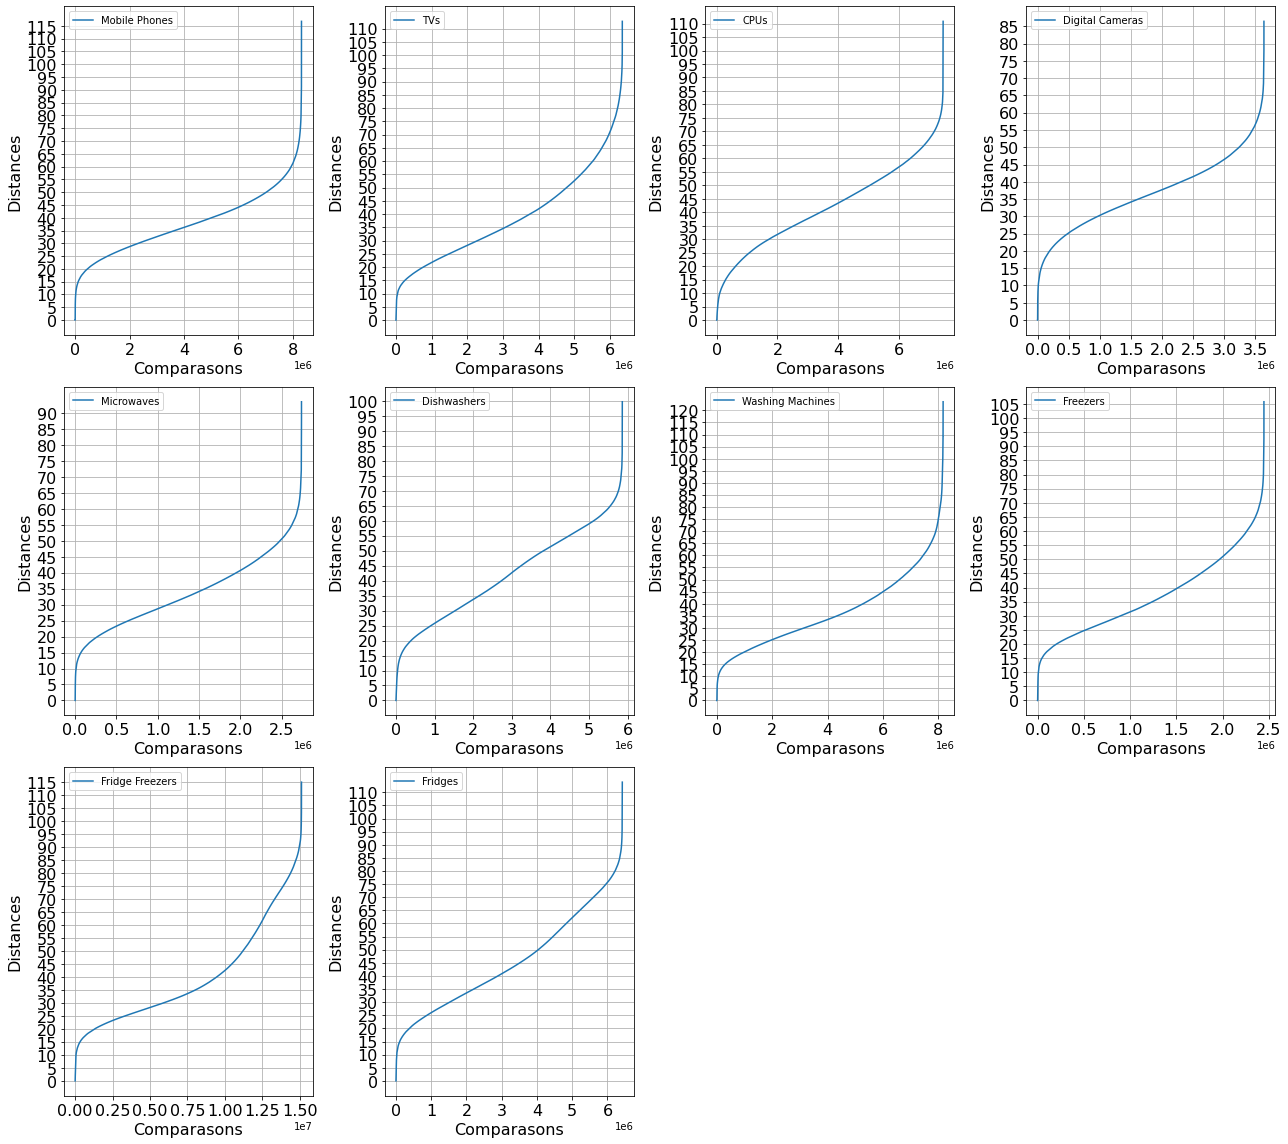

In [67]:
plot_dists(dists, df)

# Buscando altura para corte da árvore de grupos para caga categoria.

### Como estratégia para otimizar o corte dentro do intervalo [10,55] (salto de duas unidades) selecionamos o que nos deu melhor coeficiente de silhueta.

In [16]:
def cut_search(df, dists, r=None):
    
    pred_labels = {}
    # Para cada categoria.
    for cat_id in dists:
        # Codificando os labels.
        le = preprocessing.LabelEncoder()
        le.fit(df[df.cat_id == cat_id].cluster_id.values)
        targs = le.transform(df[df.cat_id == cat_id].cluster_id.values)
        pred_labels[cat_id] = None
        # Fazendo a busca do ponto de corte.
        print("Cat: ", cat_id)
        # Para cada categoria.
        #max_acc = 0
        cof_sil = -1
        opt_cut = -1
        max_sil = -1
        matrix = squareform(dists[cat_id])
        for cut_height in np.arange(56, 8, -2):
            #labels = fcluster(ward(dists[cat_id]), t=cut_height, criterion="distance")
            labels = cut_tree(ward(dists[cat_id]), height=cut_height)
            try:
                cof_sil = silhouette_score(matrix, labels, metric="precomputed")
            except:
                cof_sil = -1
            if cof_sil > max_sil:
                #max_acc = cluster_accuracy(targs, labels)
                max_sil = cof_sil
                opt_cut = cut_height
                pred_labels[cat_id] = labels
        print("\tCut: ", opt_cut, "Silhouette: ", cof_sil)
        print("*"*100)
    return pred_labels


In [17]:
pred_labels = cut_search(df, dists)

Cat:  2612
	Cut:  10 Silhouette:  0.36419508
****************************************************************************************************
Cat:  2614
	Cut:  10 Silhouette:  0.58376586
****************************************************************************************************
Cat:  2615
	Cut:  10 Silhouette:  0.5498942
****************************************************************************************************
Cat:  2617
	Cut:  10 Silhouette:  0.4106421
****************************************************************************************************
Cat:  2618
	Cut:  10 Silhouette:  0.43621832
****************************************************************************************************
Cat:  2619
	Cut:  10 Silhouette:  0.53316045
****************************************************************************************************
Cat:  2620
	Cut:  10 Silhouette:  0.46689853
*********************************************************************************

In [20]:
new_df = None
if RUN_AGAIN:
    for cat_id in pred_labels:
        temp = df[df.cat_id == cat_id]
        temp["predicted"] = pred_labels[cat_id]
        if new_df is None:
            new_df = temp
        else:
            new_df = pd.concat([new_df, temp])
    new_df.to_csv('datasets/classified.csv', index=False)
else:
    new_df = pd.read_csv('datasets/classified.csv')

In [25]:
pd.set_option('display.max_colwidth', None)
preds = set(new_df[new_df.cat_id == 2615].predicted)
ids = np.random.choice(list(preds), 5)
subset = None
for i in ids:
    if subset is None:
        subset = new_df[new_df.predicted == i][['p_title', 'cluster_id', 'predicted']]
    else:
        subset = pd.concat([subset, new_df[new_df.predicted == i][['p_title', 'cluster_id', 'predicted']]])
subset.head(200)

,p_title,cluster_id,predicted
1459,samsung galaxy a6 2018 smartphone gold,183,786
6375,samsung 49 smart fhd curved,4834,786
10594,amd trinity a8 5500 quad core 3.20ghz socket fm2 4mb l2 cache graphics directx 11 apu gpu fan and heatsink retail boxed processor,6990,786
10595,amd trinity a10 5700 quad core 3.40ghz socket fm2 4mb l2 cache graphics directx 11 apu gpu fan and heatsink retail boxed processor,6991,786
10596,amd trinity a4 5300 dual core 3.40ghz socket fm2 1mb l2 cache graphics directx 11 apu gpu fan and heatsink retail boxed processor,6992,786
...,...,...,...
28260,aeg sce8182vnc 177cm integrated 70/30 customflex frost free fridge freezer,44346,847
28455,aeg sce8182vts 177cm integrated 70/30 customflex frost free fridge freezer,44391,847
29122,aeg sce81864tc 177cm integrated 70/30 customflex frost free fridge freezer,44562,847
30461,candy cfbf3050ek 177cm high 50 50 split integrated frost free fridge freezer,45078,847
